In [1]:
# Set active directory to project root
import os
from molecule.config import get_project_root_directory
ROOT_PATH = get_project_root_directory()
os.chdir(ROOT_PATH)

In [2]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt

# Train / test split

In [3]:
from sklearn.model_selection import train_test_split

Let's import the original data and have a look.

In [4]:
DATASET_PATH = "data/datasets/dataset_single.csv"
df = pd.read_csv(DATASET_PATH)
print(f"Dataset contains {df.shape[0]} rows.")

Dataset contains 4999 rows.


In [5]:
df.head()

,P1,mol_id,smiles
0,1,CID2999678,Cc1cccc(N2CCN(C(=O)C34CC5CC(CC(C5)C3)C4)CC2)c1C
1,0,CID2999679,Cn1ccnc1SCC(=O)Nc1ccc(Oc2ccccc2)cc1
2,1,CID2999672,COc1cc2c(cc1NC(=O)CN1C(=O)NC3(CCc4ccccc43)C1=O...
3,0,CID5390002,O=C1/C(=C/NC2CCS(=O)(=O)C2)c2ccccc2C(=O)N1c1cc...
4,1,CID2999670,NC(=O)NC(Cc1ccccc1)C(=O)O


We'll split the dataset into train / test and save the results into 2 separate files.

In [6]:
TEST_SIZE = 1000
df_train, df_test = train_test_split(df, test_size=TEST_SIZE, random_state=42)
print(f"Train set contains {df_train.shape[0]} rows, test set {df_test.shape[0]}.")

Train set contains 3999 rows, test set 1000.


In [7]:
df_train.to_csv("data/datasets/dataset_single_train.csv", index=False)
df_test.to_csv("data/datasets/dataset_single_test.csv", index=False)

# Basic exploration

In [8]:
from molecule.representation.dataset import Dataset

INFO:rdkit:Enabling RDKit 2022.03.4 jupyter extensions


In [9]:
from rdkit import Chem
from rdkit.Chem import Draw

Let's load the training data into a Dataset so that we can easily extract features, properties etc

In [10]:
dataset = Dataset(df_train)
smiles = dataset.smiles
labels = dataset.labels

In [11]:
print(f"Fraction of molecule with property P1: {labels.mean():.3f}")

Fraction of molecule with property P1: 0.822


Most of the molecules seem to have property P1 (the dataset is imbalanced).

Let's have a look at a few molecules and properties

Smile: c1ccc(-c2nnc(CSc3nncs3)o2)cc1
P1: 1


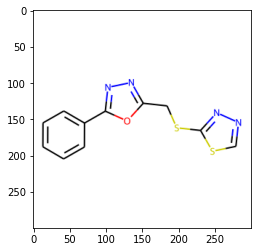

Smile: Cc1occc1C(=O)NCCCCNC(=O)c1ccoc1C
P1: 1


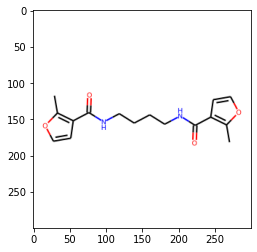

Smile: Cc1ccc(-c2cc(C(=O)NCCN3CCOCC3)no2)cc1
P1: 0


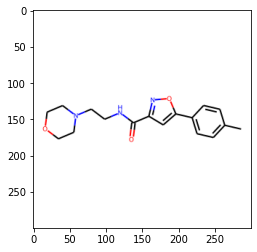

Smile: CN(C)C(=O)Cn1c(SCC(=O)N2CCCc3ccccc32)nc2ccccc21
P1: 1


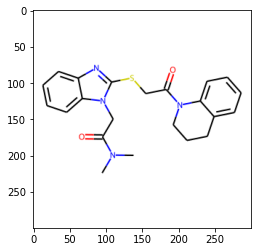

Smile: Cc1cccc(N(CC(=O)Nc2ccc(-c3nc4ccc(C)cc4s3)cc2)S(C)(=O)=O)c1
P1: 1


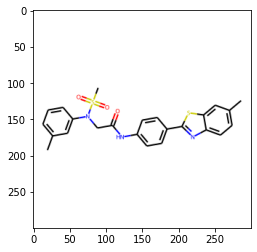

Smile: COc1ccc(CCn2c(N3CCN(Cc4ccccc4)CC3)nc3c2c(=O)[nH]c(=O)n3C)cc1
P1: 1


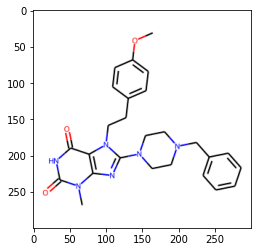

Smile: COc1cc(C(=O)N(Cc2ccc(N(C)C)cc2)C2CCS(=O)(=O)C2)cc(OC)c1OC
P1: 0


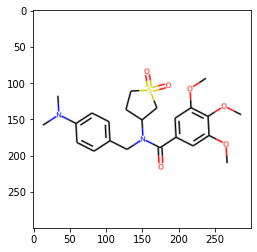

Smile: O=C(/C=C/c1ccc([N+](=O)[O-])cc1)NCc1cccnc1
P1: 1


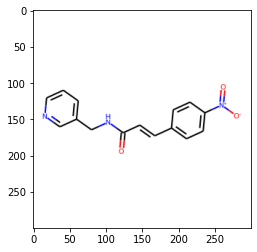

Smile: Cc1cc(C)c(C)c(S(=O)(=O)N2CCN(CC(=O)NC(=O)NCc3ccccc3)CC2)c1C
P1: 1


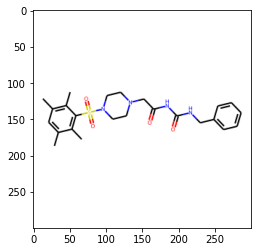

Smile: O=S(=O)(c1ccc2c(c1)OCCO2)N1CCN(Cc2ccc3c(c2)OCO3)CC1
P1: 1


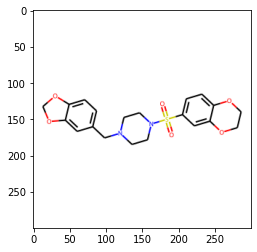

In [12]:
for smile, p1 in list(zip(smiles, labels))[:10]:
    print(f"Smile: {smile}")
    print(f"P1: {p1}")
    mol = Chem.MolFromSmiles(smile)
    img = Draw.MolToImage(mol)
    plt.imshow(img)
    plt.show()

The link between the molecule shape and the property P1 does not seem obvious to the untrained eye.

# Morgan fingerprints

In [13]:
from molecule.prediction.model import FeatureType

In [14]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

Let's use Morgan fingerprints as features

In [15]:
X = dataset.get_features(feature_type=FeatureType.MORGAN)
X.shape

(3999, 2048)

In [16]:
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]])

Let's quickly visualize the first 50 features of the first 40 samples

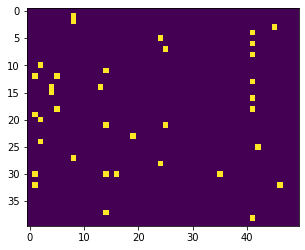

In [17]:
plt.imshow(X[:40,:50])
plt.show()

The features seem sparse

Are there strong links between features? (i.e. do we need 2048 features, are could we reduce that?)

In [18]:
pca = PCA()
pca.fit(X)

PCA()

In [19]:
print(f"Variance explained by 1st component: {pca.explained_variance_ratio_[0]:.3f}")
print(f"Variance explained by first 10 components: {pca.explained_variance_ratio_[:10].sum():.3f}")
print(f"Variance explained by 1/4 of components: {pca.explained_variance_ratio_[:512].sum():.3f}")
print(f"Variance explained by 1/2 of components: {pca.explained_variance_ratio_[:1024].sum():.3f}")

Variance explained by 1st component: 0.026
Variance explained by first 10 components: 0.176
Variance explained by 1/4 of components: 0.860
Variance explained by 1/2 of components: 0.959


We can keep keep most of the variance of the dataset by projecting it onto a space with 1/4 of the initial dimensions, so there are some correlations among features.

Let's try visualize the high-dimensional data.

In [20]:
tsne = TSNE(perplexity=20, random_state=42)

In [21]:
%%time
vis = tsne.fit_transform(X)

/home/yannick/miniconda3/envs/servier/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/yannick/miniconda3/envs/servier/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


CPU times: user 1min 11s, sys: 1.36 s, total: 1min 12s
Wall time: 9.42 s


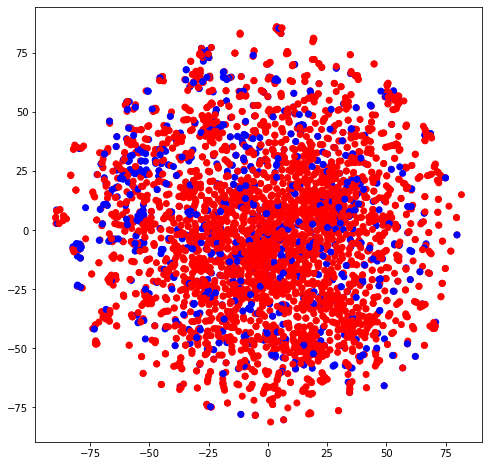

In [22]:
plt.figure(figsize=(8,8))
plt.scatter(*vis.T, c=labels, cmap=plt.cm.bwr)
plt.show()

There doesn't seem to be a clear pattern between the high dimensional features and the property to be predicted. The task is likely to be challenging.

Since the dataset is imbalanced and the task seems challenging, accuracy is unlikely to be a good metric for our classification task. We will prefer other metrics such as Area Under Curve (AUC) of a Receiver Operating Characteristic (ROC), or precision and recall.